In [63]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%autosave 20
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Autosaving every 20 seconds


In [32]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm import tqdm
import joblib
from sklearn.linear_model import LinearRegression

### Reading the data

In [3]:
df = pd.read_csv("Truck_price_prediction.csv")
df.head()
df_backup = df.copy() # Deep Copy

,Trip_Distance_km,Starting_Day,Day_of_Week,Palette_Count,Load_Count,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,193.5,Morning,Weekday,3.0,Low,Clear,35.6,0.80,0.32,538.2,362.624
1,475.9,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,405.7,NaN
2,368.7,Evening,Weekend,1.0,High,Clear,27.0,1.21,0.15,372.7,529.032
3,303.3,Evening,Weekday,4.0,Low,NaN,34.8,0.51,0.15,1168.1,364.698
4,NaN,Evening,Weekday,3.0,High,Clear,29.3,0.63,0.32,226.4,156.180


### Lets Get some Idea about our Data

In [4]:
df.shape

(1000, 11)

In [6]:
df.isna().sum()
# I could see Lot of missing data points . May be These are data problem . For all Columns I coud see 50 Values missing

print(f"{(50/1000)*100}% data points are null ")

Trip_Distance_km         50
Starting_Day             50
Day_of_Week              50
Palette_Count            50
Load_Count               50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64

5.0% data points are null 


In [7]:
#WE have mix of Floats and Objects . Our target column is Float i.e Trip Price
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Starting_Day           950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Palette_Count          950 non-null    float64
 4   Load_Count             950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Trip_Distance_km,950.0,270.705469,199.052998,12.300,126.3250,258.300,384.0500,1460.670472
Palette_Count,950.0,2.476842,1.102249,1.000,1.2500,2.000,3.0000,4.000000
Base_Fare,950.0,35.029895,8.701619,20.100,27.3000,35.200,42.6000,50.000000
Per_Km_Rate,950.0,1.233316,0.429816,0.500,0.8600,1.220,1.6100,2.000000
Per_Minute_Rate,950.0,0.292916,0.115592,0.100,0.1900,0.290,0.3900,0.500000
Trip_Duration_Minutes,950.0,621.181158,321.544065,50.100,358.8250,618.600,890.5500,1198.400000
Trip_Price,951.0,568.747733,404.697906,61.269,337.4265,500.745,690.9935,3320.436887


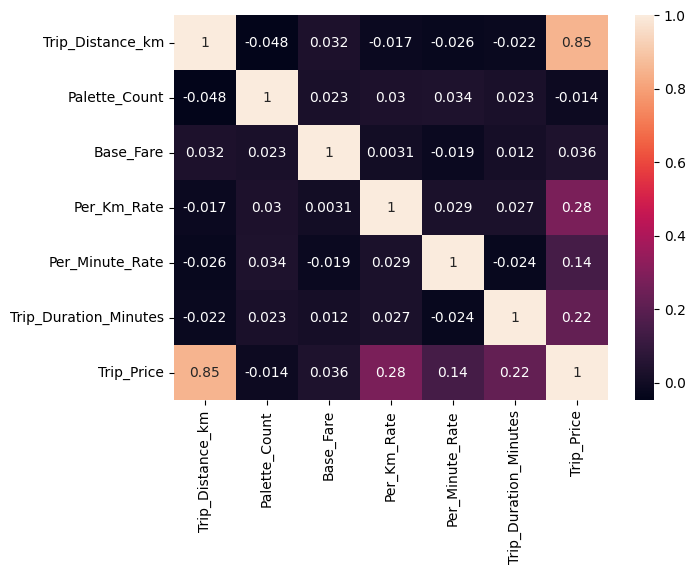

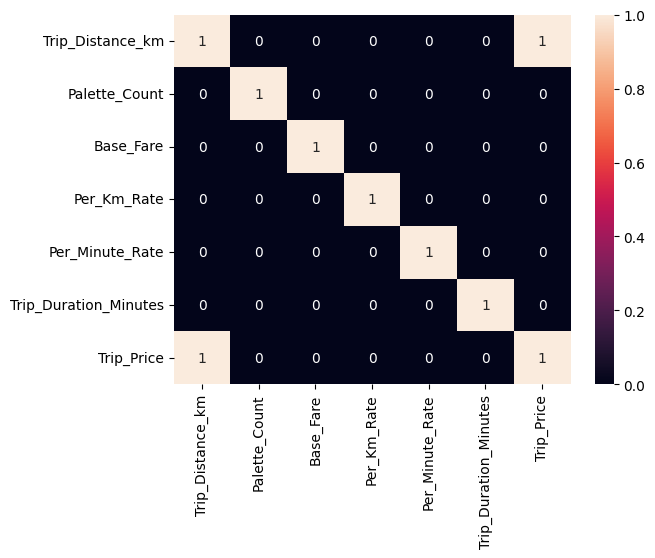

In [9]:
_ = plt.subplots(figsize= (7,5)) 
cor = df[['Trip_Distance_km', 'Palette_Count', 'Base_Fare', 'Per_Km_Rate','Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']].corr()
_ = sns.heatmap(cor,annot = True)
_= plt.show()
_ = sns.heatmap(cor.abs() > .5,annot = True)
_= plt.show()

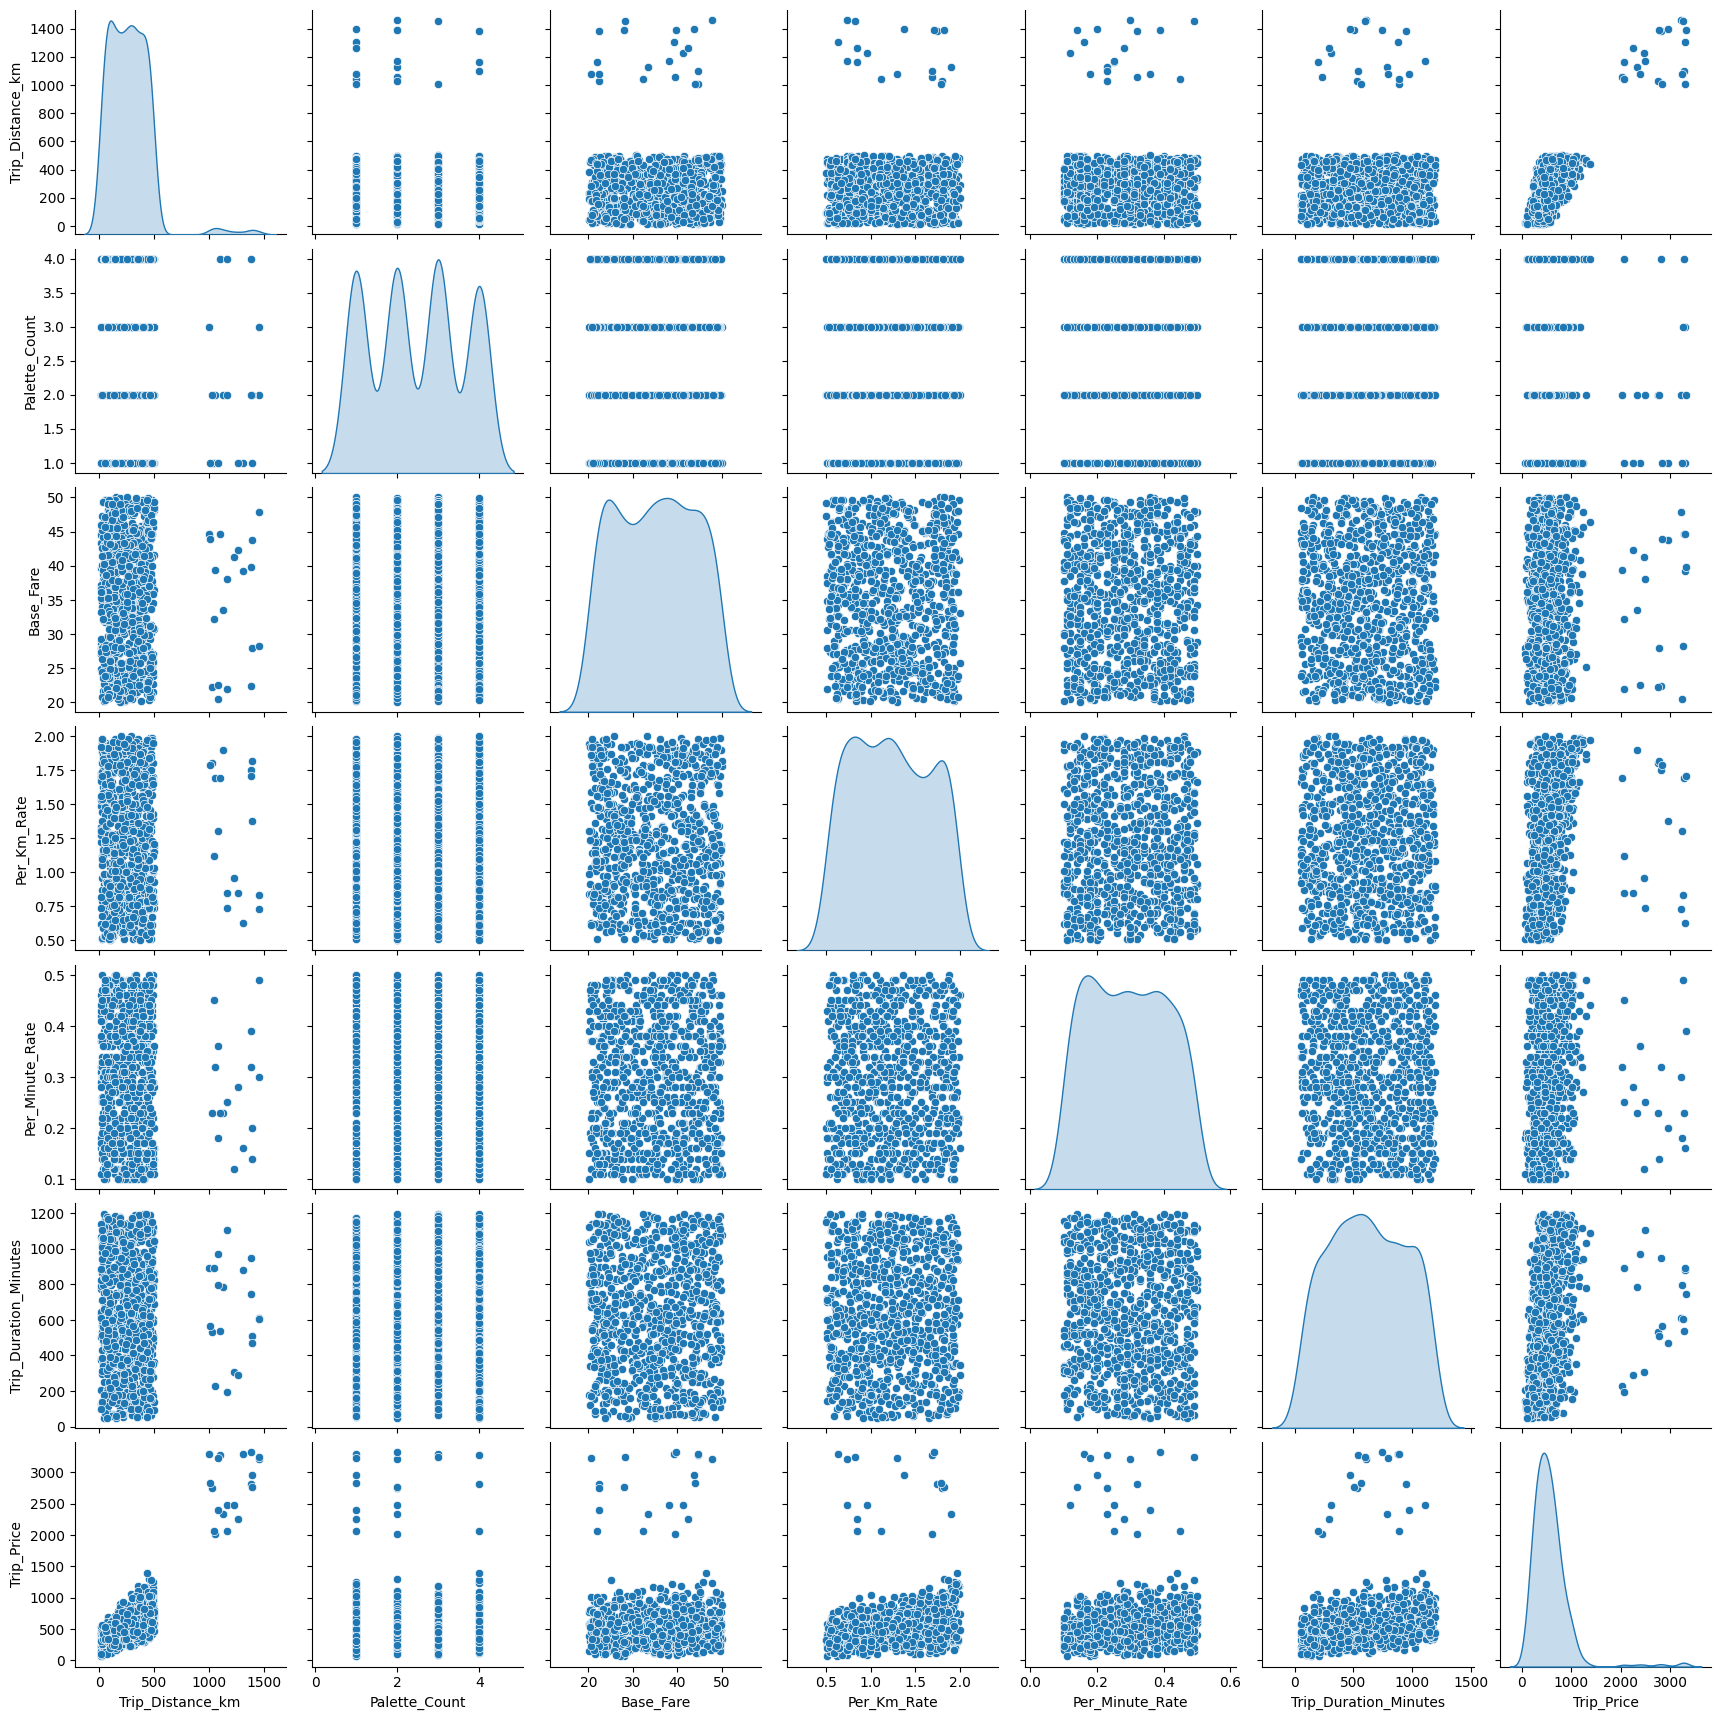

In [10]:
_ = sns.pairplot(df,diag_kind='kde')
#I couldn't see any Trend Here in the data But this is too early to tell

In [13]:
"""This data Dosent any tend / Very few trend  with Targer Variable except Trip Distance Km Column . 
If i think on Regression Based i should say There are less variable which can Explain the Price"""

'This data Dosent any tend / Very few trend  with Targer Variable except Trip Distance Km Column . \nIf i think on Regression Based i should say There are less variable which can Explain the Price'

<Axes: xlabel='Trip_Price', ylabel='Count'>

Text(0.5, 1.0, 'Trip_Price')

Text(0.5, 0, 'Price')

Text(0, 0.5, 'Frequency')

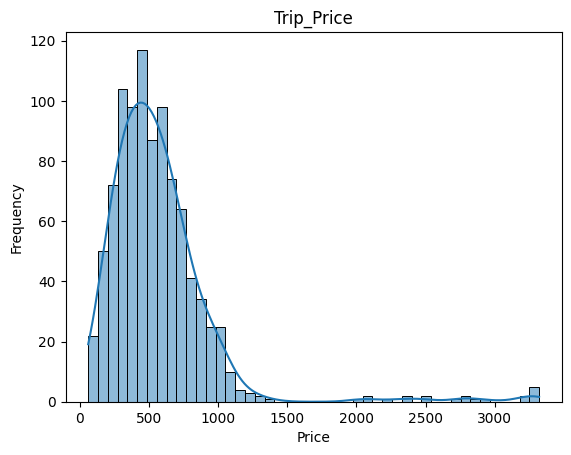

In [14]:
sns.histplot(df['Trip_Price'], kde=True)  
plt.title("Trip_Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In [15]:
#feature categorization 
numerical_features = ['Trip_Distance_km', 'Palette_Count', 'Base_Fare','Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']
categorical_features = ['Starting_Day','Day_of_Week','Load_Count','Weather']

### Visualizing the Distribution of Numerical Features to determine Imputation Strategy.
Here we can see that the mean and median of all the features are close to each other.

<Figure size 600x400 with 0 Axes>

<Axes: title={'center': 'Trip_Distance_km'}, ylabel='Frequency'>

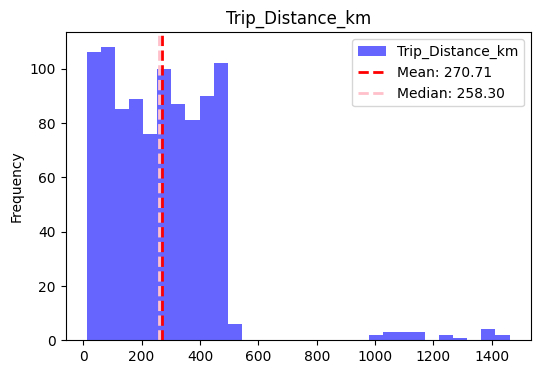

<Figure size 600x400 with 0 Axes>

<Axes: title={'center': 'Palette_Count'}, ylabel='Frequency'>

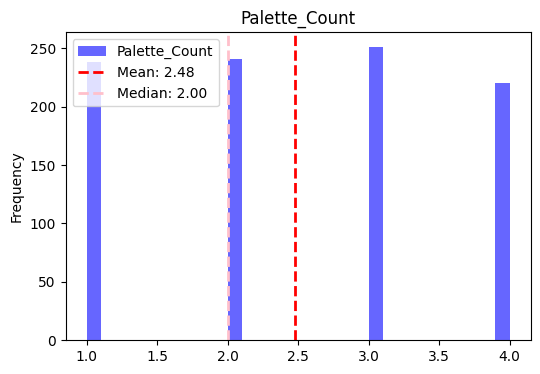

<Figure size 600x400 with 0 Axes>

<Axes: title={'center': 'Base_Fare'}, ylabel='Frequency'>

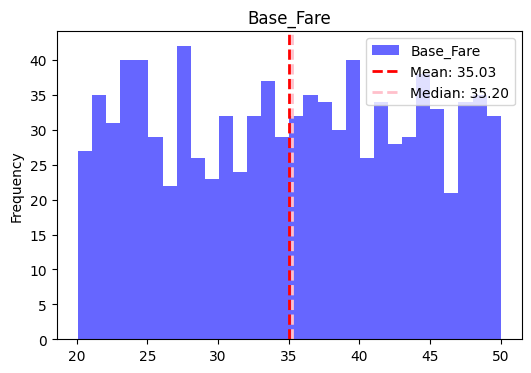

<Figure size 600x400 with 0 Axes>

<Axes: title={'center': 'Per_Km_Rate'}, ylabel='Frequency'>

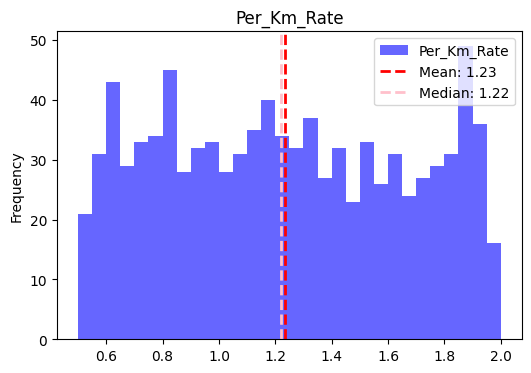

<Figure size 600x400 with 0 Axes>

<Axes: title={'center': 'Per_Minute_Rate'}, ylabel='Frequency'>

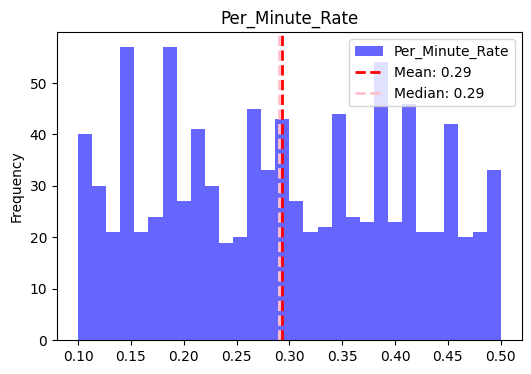

<Figure size 600x400 with 0 Axes>

<Axes: title={'center': 'Trip_Duration_Minutes'}, ylabel='Frequency'>

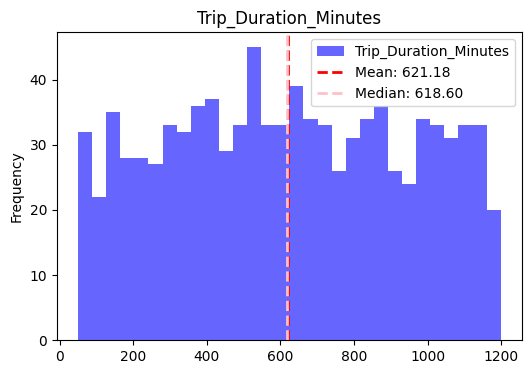

<Figure size 600x400 with 0 Axes>

<Axes: title={'center': 'Trip_Price'}, ylabel='Frequency'>

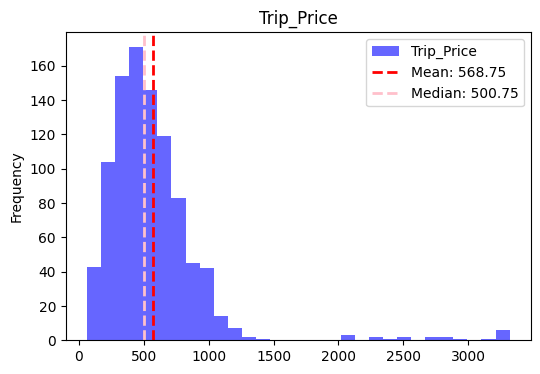

In [16]:
for i in numerical_features:
    plt.figure(figsize=(6, 4))  
    df[i].plot(kind='hist', bins=30, title=i, alpha=0.6, color='blue')  
    mean_val = df[i].mean()
    median_val = df[i].median()    
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_val:.2f}")
    plt.axvline(median_val, color='pink', linestyle='dashed', linewidth=2, label=f"Median: {median_val:.2f}")   
    plt.legend()  
    plt.show()  

### Lets Try to Fill the Missing Value and See

In [17]:
'''Keep in mind I am Not changing the Distribution Much By Adding Values in Median . Playing safe .
But this I can do only With Continuous Column '''

'Keep in mind I am Not changing the Distribution Much By Adding Values in Median . Playing safe .\nBut this I can do only With Continuous Column '

#### Median Imputation

In [18]:
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())

In [19]:
df.isnull().sum()

Trip_Distance_km          0
Starting_Day             50
Day_of_Week              50
Palette_Count             0
Load_Count               50
Weather                  50
Base_Fare                 0
Per_Km_Rate               0
Per_Minute_Rate           0
Trip_Duration_Minutes     0
Trip_Price                0
dtype: int64

#### Mode Imputation

In [20]:

df[categorical_features] = df[categorical_features].fillna(df[categorical_features].mode().iloc[0])

#### How much Changes Happened 

In [21]:
df.describe()

,Trip_Distance_km,Palette_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,270.085195,2.453000,35.038400,1.232650,0.292770,621.052100,565.415599
std,194.026610,1.079331,8.481147,0.418932,0.112664,313.394637,394.921295
min,12.300000,1.000000,20.100000,0.500000,0.100000,50.100000,61.269000
25%,131.075000,2.000000,27.700000,0.870000,0.197500,371.075000,345.788500
50%,258.300000,2.000000,35.200000,1.220000,0.290000,618.600000,500.745000
75%,377.825000,3.000000,42.025000,1.580000,0.382500,877.750000,674.766500
max,1460.670472,4.000000,50.000000,2.000000,0.500000,1198.400000,3320.436887


In [22]:
df_backup.describe()

,Trip_Distance_km,Palette_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,951.000000
mean,270.705469,2.476842,35.029895,1.233316,0.292916,621.181158,568.747733
std,199.052998,1.102249,8.701619,0.429816,0.115592,321.544065,404.697906
min,12.300000,1.000000,20.100000,0.500000,0.100000,50.100000,61.269000
25%,126.325000,1.250000,27.300000,0.860000,0.190000,358.825000,337.426500
50%,258.300000,2.000000,35.200000,1.220000,0.290000,618.600000,500.745000
75%,384.050000,3.000000,42.600000,1.610000,0.390000,890.550000,690.993500
max,1460.670472,4.000000,50.000000,2.000000,0.500000,1198.400000,3320.436887


### What Difference in Corr i could see ?

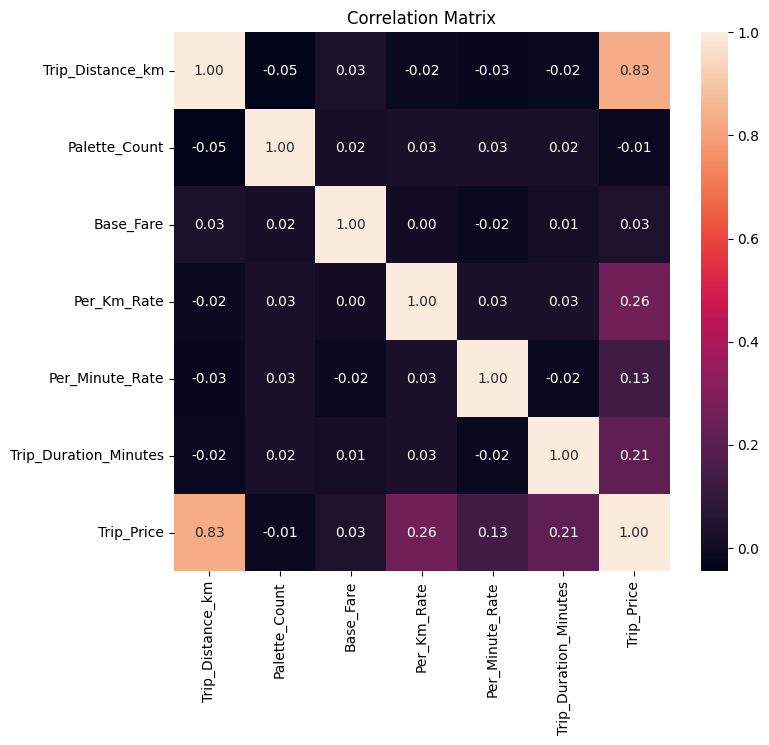

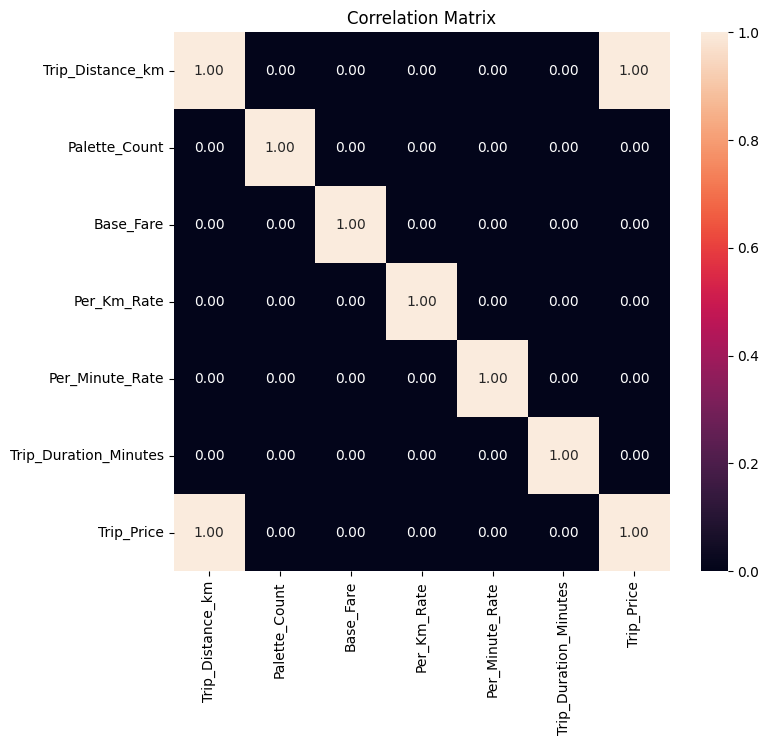

In [23]:
numeric_df = df.select_dtypes(include=['number'])
corre = numeric_df.corr()

_ = plt.figure(figsize=(8, 7))
_ = sns.heatmap(corre, annot=True, fmt=".2f", cbar=True)
_ = plt.title('Correlation Matrix')
_ = plt.show()

_ = plt.figure(figsize=(8, 7))
_ = sns.heatmap(corre.abs() > 0.5, annot=True, fmt=".2f", cbar=True)
_ = plt.title('Correlation Matrix')
_ = plt.show()

## Data Preprocessing

### I need the Categorical column to be Computer understandable

The advantages of one-hot encoding are:

- No Implicit Order: It avoids assigning arbitrary numeric values to categories (e.g., 1 for "Red," 2 for "Blue"). This would imply that "Blue" is somehow "greater" than "Red." One-hot encoding treats all categories equally, with no built-in order.

- Better Model Performance: By converting categorical data into a numerical format, one-hot encoding makes it usable for machine learning models like decision trees, neural networks, or regression, which typically only accept numbers.

- Improved Accuracy: Since the machine learning model can now correctly differentiate between categories, it often results in better performance and more accurate predictions.

- Simplicity: The process is simple and can be easily automated. It doesn't require complex transformations or assumptions, making it a practical choice for many types of data.

In [24]:
#One Hot Encoding
df = pd.get_dummies(df, columns = categorical_features, drop_first=True)

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Box plot for Starting_Day_Evening vs Trip_Price')

<Axes: title={'center': 'Box plot for Starting_Day_Evening vs Trip_Price'}, xlabel='Trip_Price', ylabel='Starting_Day_Evening'>

Text(0.5, 0, 'Trip Price')

Text(0, 0.5, 'Starting_Day_Evening')

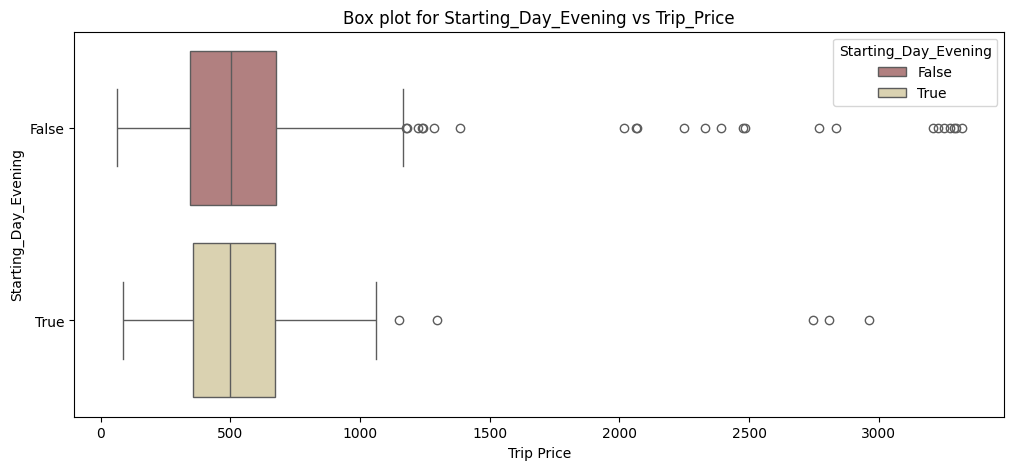

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Box plot for Starting_Day_Morning vs Trip_Price')

<Axes: title={'center': 'Box plot for Starting_Day_Morning vs Trip_Price'}, xlabel='Trip_Price', ylabel='Starting_Day_Morning'>

Text(0.5, 0, 'Trip Price')

Text(0, 0.5, 'Starting_Day_Morning')

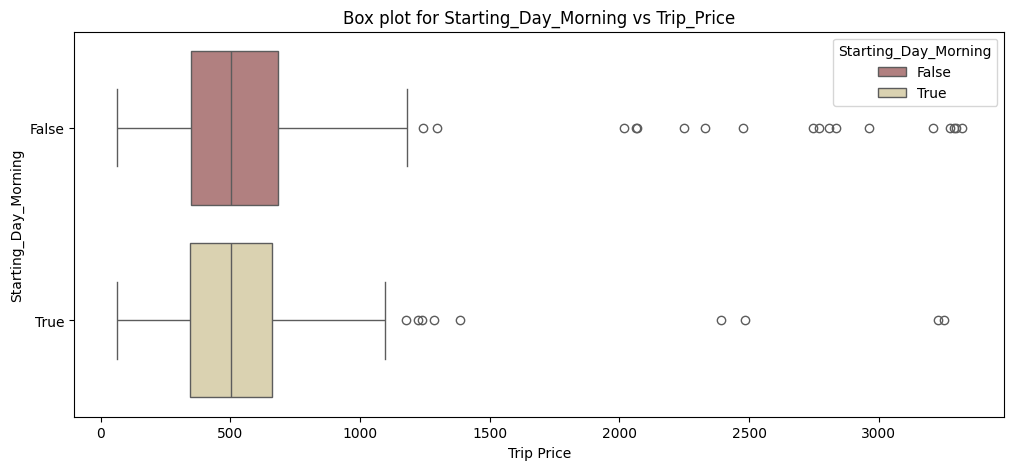

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Box plot for Starting_Day_Night vs Trip_Price')

<Axes: title={'center': 'Box plot for Starting_Day_Night vs Trip_Price'}, xlabel='Trip_Price', ylabel='Starting_Day_Night'>

Text(0.5, 0, 'Trip Price')

Text(0, 0.5, 'Starting_Day_Night')

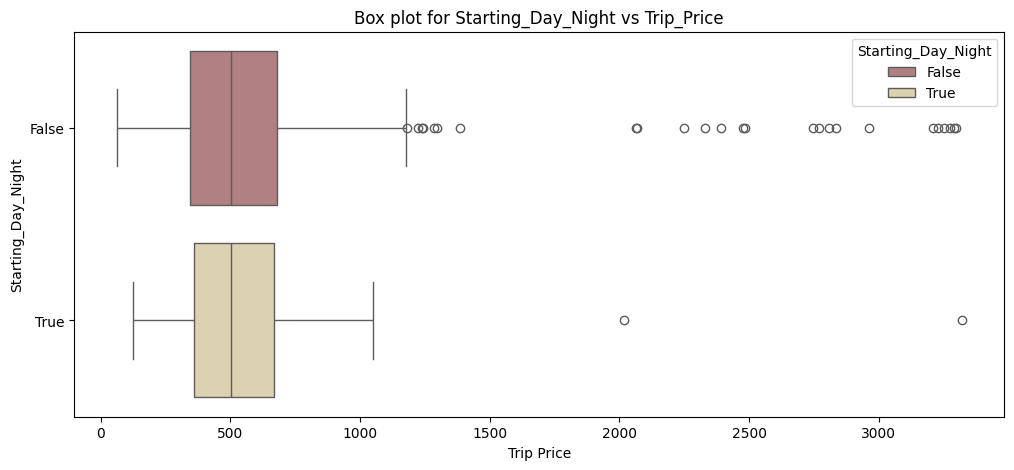

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Box plot for Day_of_Week_Weekend vs Trip_Price')

<Axes: title={'center': 'Box plot for Day_of_Week_Weekend vs Trip_Price'}, xlabel='Trip_Price', ylabel='Day_of_Week_Weekend'>

Text(0.5, 0, 'Trip Price')

Text(0, 0.5, 'Day_of_Week_Weekend')

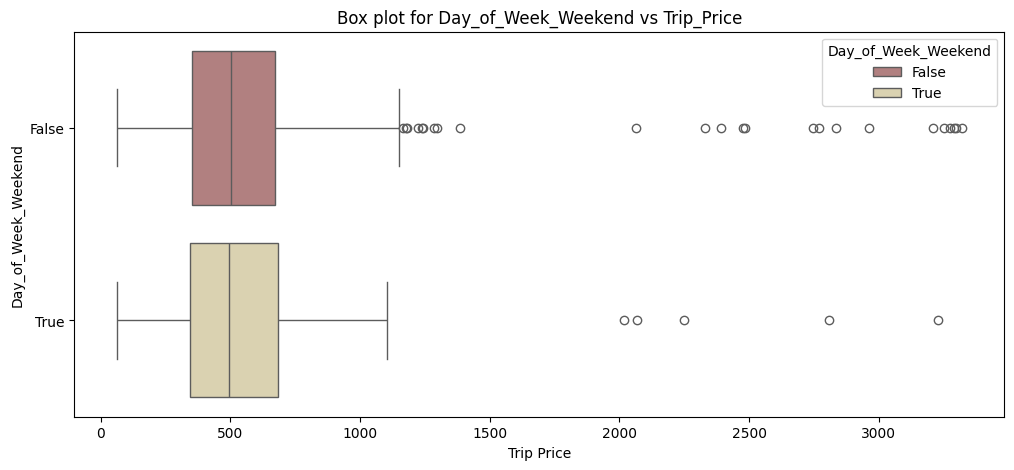

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Box plot for Load_Count_Low vs Trip_Price')

<Axes: title={'center': 'Box plot for Load_Count_Low vs Trip_Price'}, xlabel='Trip_Price', ylabel='Load_Count_Low'>

Text(0.5, 0, 'Trip Price')

Text(0, 0.5, 'Load_Count_Low')

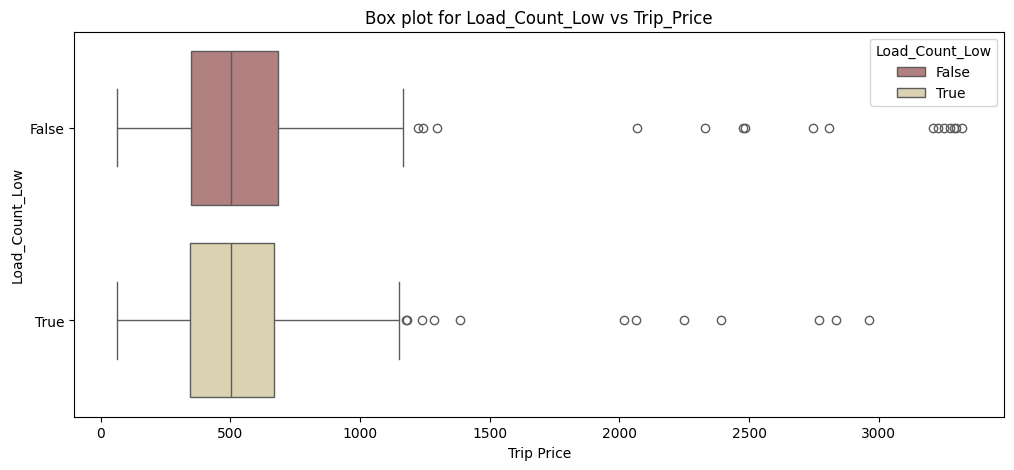

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Box plot for Load_Count_Medium vs Trip_Price')

<Axes: title={'center': 'Box plot for Load_Count_Medium vs Trip_Price'}, xlabel='Trip_Price', ylabel='Load_Count_Medium'>

Text(0.5, 0, 'Trip Price')

Text(0, 0.5, 'Load_Count_Medium')

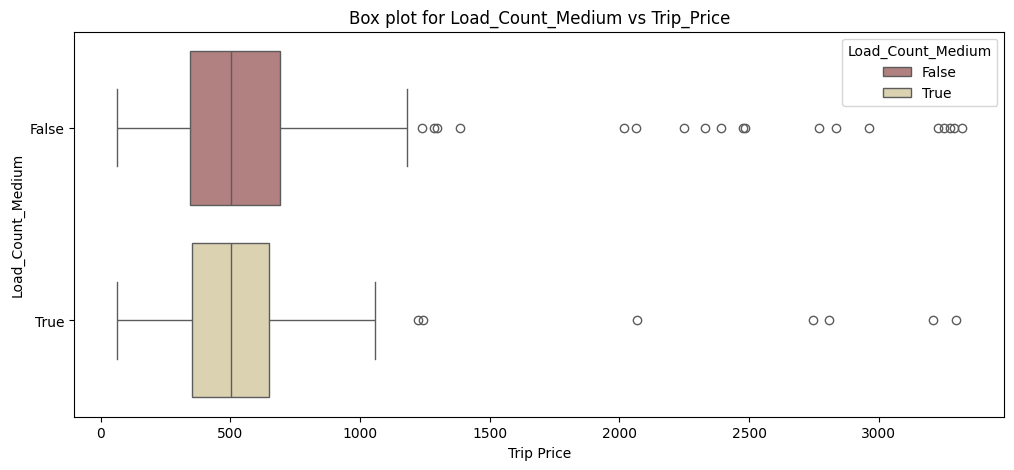

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Box plot for Weather_Rain vs Trip_Price')

<Axes: title={'center': 'Box plot for Weather_Rain vs Trip_Price'}, xlabel='Trip_Price', ylabel='Weather_Rain'>

Text(0.5, 0, 'Trip Price')

Text(0, 0.5, 'Weather_Rain')

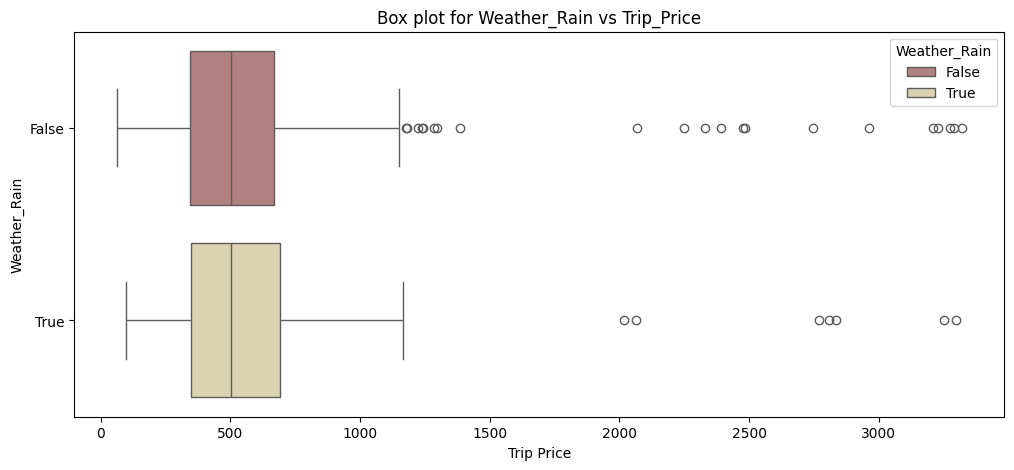

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Box plot for Weather_Snow vs Trip_Price')

<Axes: title={'center': 'Box plot for Weather_Snow vs Trip_Price'}, xlabel='Trip_Price', ylabel='Weather_Snow'>

Text(0.5, 0, 'Trip Price')

Text(0, 0.5, 'Weather_Snow')

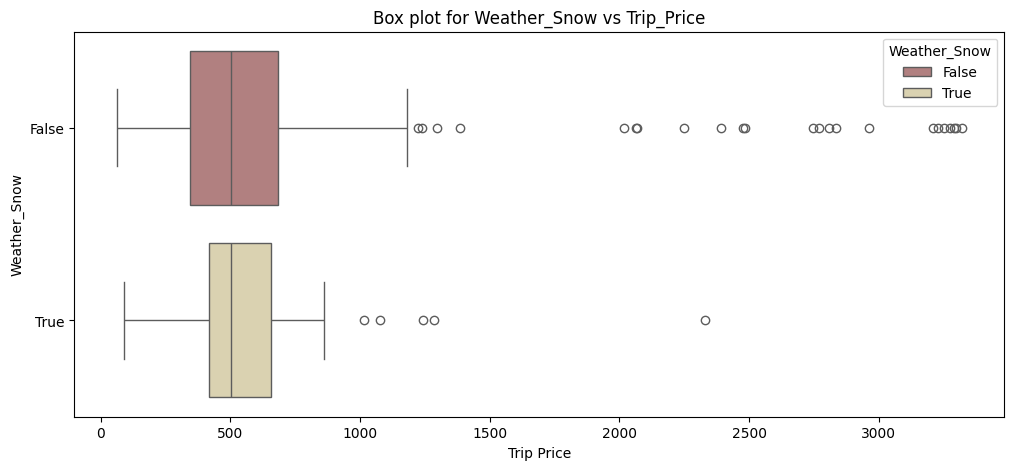

In [62]:
categorical_columns = [
    'Starting_Day_Evening', 'Starting_Day_Morning', 'Starting_Day_Night',
    "Day_of_Week_Weekend",
    'Load_Count_Low', 'Load_Count_Medium',
    "Weather_Rain","Weather_Snow"
]

for col in categorical_columns:
    plt.figure(figsize=(12, 5))
    plt.title(f"Box plot for {col} vs Trip_Price")
    sns.boxplot(
        y=col, 
        x="Trip_Price", 
        data=df, 
        orient="h",
        hue = col,
        palette= "pink"
    )
    plt.xlabel("Trip Price")
    plt.ylabel(col)
    plt.show()

The plots reveal that Trip_Price remains fairly consistent across these columns. This suggests that factors like time of day, day of the week, traffic conditions, and weather may not have a significant impact on trip pricing within this dataset.

### All we did will Come to Result when we do our modeling . But Yes its too early , We can let our creativity go wild !!!

In [25]:
from IPython.display import display, HTML

url = "https://s.yimg.com/ny/api/res/1.2/NbhyugwyTRHQxPqWO9scqQ--/YXBwaWQ9aGlnaGxhbmRlcjt3PTEyNDI7aD0xMjQy/https://media.zenfs.com/en/aol_bored_panda_979/f4dd9b7818e29b1a8a9aafb2a2e6a95e"
display(HTML(f'<a href="{url}" target="_blank" style="font-size:20px; font-weight:bold;">Do not Click on this Link if You feeling Sleepy</a>'))


In [26]:
# Identify What is X and What is Y .BE carefull Here
X = df.drop(['Trip_Price'], axis=1)
y = df['Trip_Price']
features = X.columns

In [27]:
#Scaling our numerical features using RobustScaler

numeric_columns = ['Trip_Distance_km', 'Palette_Count', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[numeric_columns] = scaler.fit_transform(X[numeric_columns])

In [41]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.20, random_state=42)

In [51]:
#Linear Regression is the starting point.

lr = LinearRegression().fit(X_train, y_train)
y_train_predict = lr.predict(X_train)
y_test_predict = lr.predict(X_test)
print(f'R2 score for train data : {lr.score(X_train, y_train)}')
print(f'R2 score for test data : {lr.score(X_test, y_test)}')

R2 score for train data : 0.843573191408765
R2 score for test data : 0.7687333242402591


Visualize predictions vs actual


<Figure size 600x400 with 0 Axes>

Text(0.5, 0, 'Actual Price')

Text(0, 0.5, 'Predicted Price')

Text(0.5, 1.0, 'Linear Regression: Actual vs Predicted Prices')

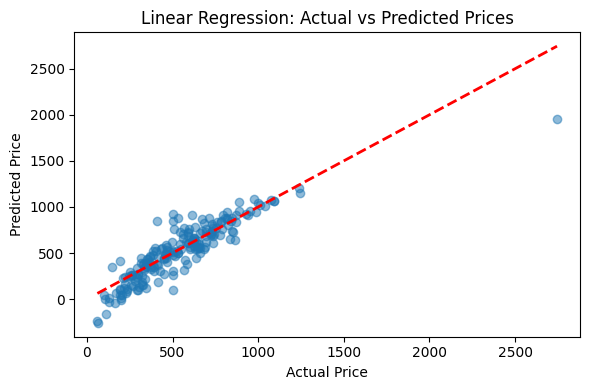

In [46]:
# Visualize predictions vs actual (The best fit line)
print("Visualize predictions vs actual")
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_test_predict, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual vs Predicted Prices')
plt.tight_layout()
plt.show()

In [47]:
#XGBoost
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

In [31]:
param_xgb = {
    'n_estimators': [100, 200],  
    'learning_rate': [0.2],  
    'max_depth': [5, 10],
    'subsample': [0.8, 1.0],
    'min_child_weight': [ 3, 5]    
}

param_combinations = list(ParameterGrid(param_xgb))
pbar = tqdm(total=len(param_combinations) * 5)  # Multiply by CV folds

grid_search_xgb = GridSearchCV(xgb_regressor, param_xgb, cv=5, verbose=0)

for _ in param_combinations:
    grid_search_xgb.fit(X_train, y_train)
    pbar.update(5)  # Update progress for each CV fold

pbar.close()
best_gs_xgb = grid_search_xgb.best_estimator_


%|                                                                                                        | 0/80 [00:00<?, ?it/s]

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|██████                                                                                          | 5/80 [00:36<09:05,  7.27s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|███████████▉                                                                                   | 10/80 [01:11<08:19,  7.13s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|█████████████████▊                                                                             | 15/80 [01:44<07:28,  6.89s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|███████████████████████▊                                                                       | 20/80 [02:16<06:42,  6.71s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|█████████████████████████████▋                                                                 | 25/80 [02:49<06:05,  6.64s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|███████████████████████████████████▋                                                           | 30/80 [03:20<05:25,  6.51s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|█████████████████████████████████████████▌                                                     | 35/80 [03:51<04:48,  6.41s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|███████████████████████████████████████████████▌                                               | 40/80 [04:25<04:20,  6.52s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|█████████████████████████████████████████████████████▍                                         | 45/80 [04:58<03:48,  6.54s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|███████████████████████████████████████████████████████████▍                                   | 50/80 [05:31<03:17,  6.57s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|█████████████████████████████████████████████████████████████████▎                             | 55/80 [06:04<02:44,  6.58s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|███████████████████████████████████████████████████████████████████████▎                       | 60/80 [06:38<02:12,  6.62s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|█████████████████████████████████████████████████████████████████████████████▏                 | 65/80 [07:10<01:38,  6.56s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|███████████████████████████████████████████████████████████████████████████████████▏           | 70/80 [07:43<01:06,  6.61s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|█████████████████████████████████████████████████████████████████████████████████████████      | 75/80 [08:16<00:32,  6.59s/it]

True

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.2], 'max_depth': [5, 10],
                         'min_child_weight': [3, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]})


%|███████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [08:48<00:00,  6.55s/it]

True

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [08:48<00:00,  6.61s/it]


### Final Prediction

In [48]:
train_score = round(best_gs_xgb.score(X_train,y_train),2)
test_score = round(best_gs_xgb.score(X_test,y_test),2)
print(best_gs_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [64]:
print (f"Test_score is {test_score * 100}")

Test_score is 93.0


### After trying different models, we have our best model . Lets Agree on this for now

In [ ]:
# Save the trained model and scaler

joblib.dump(best_gs_xgb, "Model_objects/xgb_model_V1.pkl")
joblib.dump(scaler, "Model_objects/scaler_V1.pkl")

### Now Let's modularize the code

In [ ]:
import pandas as pd
import xgboost as xgb
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Data Preprocessor Class
class DataPreprocessor:
    def __init__(self, df):
        self.df = df.copy()
    
    def fill_missing_values(self):
        numeric_columns = ['Trip_Distance_km', 'Palette_Count', 'Base_Fare', 'Per_Km_Rate', 
                           'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Trip_Price']
        categorical_columns = ['Starting_Day', 'Day_of_Week', 'Load_Count', 'Weather']
        
        self.df[numeric_columns] = self.df[numeric_columns].fillna(self.df[numeric_columns].median())
        self.df[categorical_columns] = self.df[categorical_columns].fillna(self.df[categorical_columns].mode().iloc[0])
    
    def one_hot_encode(self):
        categorical_columns = ['Starting_Day', 'Day_of_Week', 'Load_Count', 'Weather']
        self.df = pd.get_dummies(self.df, columns=categorical_columns, drop_first=True)
    
    def preprocess(self):
        self.fill_missing_values()
        self.one_hot_encode()
        return self.df

# Model Training Class
class ModelTrainer:
    def __init__(self, df):
        self.df = df
        self.X = self.df.drop(columns=['Trip_Price'])
        self.y = self.df['Trip_Price']
        self.scaler = RobustScaler()
        self.model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    
    def prepare_data(self):
        numeric_columns = ['Trip_Distance_km', 'Palette_Count', 'Base_Fare', 'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']
        self.X[numeric_columns] = self.scaler.fit_transform(self.X[numeric_columns])
        return train_test_split(self.X, self.y, test_size=0.2, random_state=42)

    def train_model(self):
        X_train, X_test, y_train, y_test = self.prepare_data()
        param_grid = {'n_estimators': [100], 'learning_rate': [0.2], 'max_depth': [5], 
                      'subsample': [0.8], 'min_child_weight': [5]}
        
        grid_search = GridSearchCV(self.model, param_grid, cv=3, n_jobs=-1, error_score='raise')
        grid_search.fit(X_train, y_train)
        
        return grid_search.best_estimator_, self.scaler, X_train.columns

if __name__ == "__main__":
    df = pd.read_csv("data/Truck_price_prediction.csv")
    preprocessor = DataPreprocessor(df)
    df_cleaned = preprocessor.preprocess()
    
    trainer = ModelTrainer(df_cleaned)
    model, scaler, feature_names = trainer.train_model()

    # Save the trained model and scaler
    joblib.dump(model, "Model_objects/xgb_model.pkl")
    joblib.dump(scaler, "Model_objects/scaler.pkl")
    joblib.dump(feature_names, "Model_objects/feature_names.pkl")

    print("Model training complete. Files saved.")
